# Example project work

[some descriptive text]

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mikeio
import tsod
import fmskill

In [2]:
fldr = Path("../data")
save_png = False

## 1. Plot stations on map

In [3]:
stations = pd.read_csv(
    fldr / "obs" / "observation_positions.xyz", 
    sep="\t", 
    names=["lon","lat","z","name"]
).set_index("name").drop(columns=["z"])
station_names = stations.index
stations

,lon,lat
name,,
K14,3.6333,53.2667
F16,4.0122,54.1167
L9,4.9667,53.6167
HKZA,4.0090,52.3066


In [4]:
domain = mikeio.Mesh(fldr / "input" / "SouthernNorthSea.mesh")

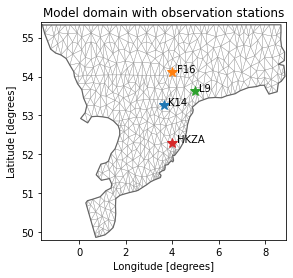

In [5]:
domain.plot.mesh();
for name, row in stations.iterrows():
    plt.plot(row.lon, row.lat, marker="*", markersize=10)
    plt.text(row.lon+0.2, row.lat, name)
    plt.title("Model domain with observation stations")

## 2. Load observations and remove outliers 

In [6]:
observations = {}
for stn in station_names:
    observations[stn] = mikeio.read(fldr / "obs" / f"{stn}.dfs0").to_dataframe()

In [7]:
observations.keys()

dict_keys(['K14', 'F16', 'L9', 'HKZA'])

Our outlier detector will mark an observation as an outlier if: 

* Value is out of range [0, 10] - non-physical values
* The gradient is too large (single outliers)

In [8]:
min_Hm0, max_Hm0 = 0.0, 10.0
max_Hm0_change_per_hour = 3.0
detector = tsod.CombinedDetector([
    tsod.RangeDetector(min_Hm0, max_Hm0),
    tsod.GradientDetector(max_gradient=max_Hm0_change_per_hour/3600), 
])

Apply outlier detector for all observation series

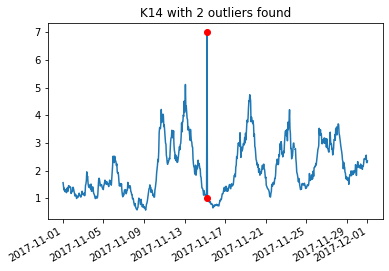

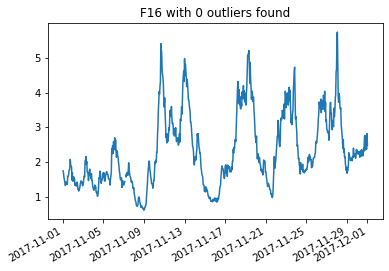

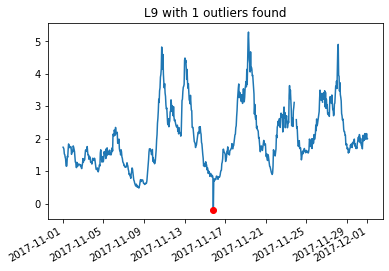

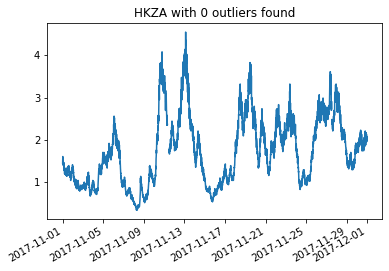

In [9]:
for stn, df in observations.items():
    anomalies = detector.detect(df.Hm0)
    n_anomalies = anomalies.sum()
    plt.plot(df)
    plt.plot(df[anomalies], 'ro', label='Anomaly');
    plt.title(f"{stn} with {n_anomalies} outliers found")
    plt.gcf().autofmt_xdate()
    plt.show()
    df[anomalies.values] = np.nan   # remove outliers

## 3. Compare with models

In [10]:
sim_folders = list(fldr.glob("sim*"))
sims = [s.name for s in sim_folders]
sims

['sim1', 'sim2', 'sim3']

In [11]:
count = 0
for sim in sims:
    fn = str(fldr / sim / "ts_significant_wave_height.dfs0")
    for stn in stations.index:
        mr = fmskill.ModelResult(fn, item=f"{stn}: Sign. Wave Height", name=f"{sim}")
        obs = fmskill.PointObservation(observations[stn], name=f"{stn}")
        obs.itemInfo = mikeio.ItemInfo(mikeio.EUMType.Significant_wave_height)
        c = fmskill.Connector(obs, mr).extract()
        cc = c if count==0 else cc + c
        count += 1

In [12]:
cc.skill().round(3)

n   bias   rmse  urmse    mae     cc     si     r2
model observation                                                       
sim1  F16           265  0.089  0.227  0.209  0.178  0.985  0.073  0.965
      HKZA         1563 -0.064  0.197  0.187  0.143  0.981  0.087  0.958
      K14           263 -0.017  0.292  0.291  0.209  0.967  0.115  0.932
      L9            264  0.129  0.270  0.238  0.212  0.978  0.091  0.943
sim2  F16           265 -0.141  0.290  0.254  0.216  0.982  0.088  0.943
      HKZA         1563 -0.311  0.420  0.283  0.328  0.979  0.132  0.810
      K14           263 -0.287  0.446  0.342  0.328  0.973  0.135  0.842
      L9            264 -0.104  0.260  0.239  0.199  0.982  0.092  0.947
sim3  F16           265 -0.348  0.491  0.346  0.376  0.973  0.120  0.836
      HKZA         1563 -0.515  0.647  0.392  0.520  0.957  0.183  0.550
      K14           263 -0.515  0.700  0.474  0.521  0.942  0.187  0.612
      L9            264 -0.346  0.521  0.389  0.380  0.962  0.150  0.787

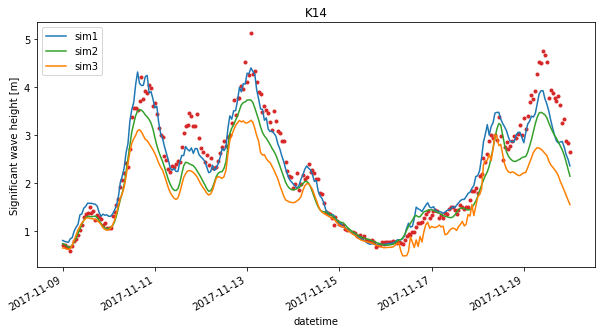

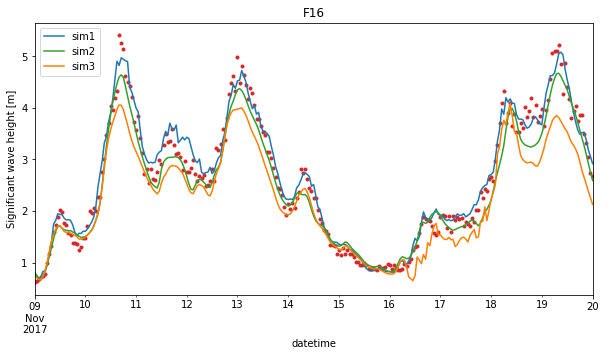

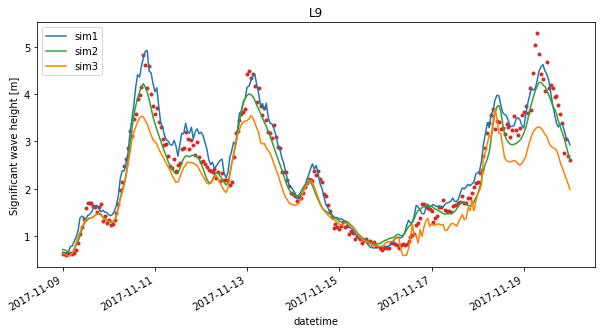

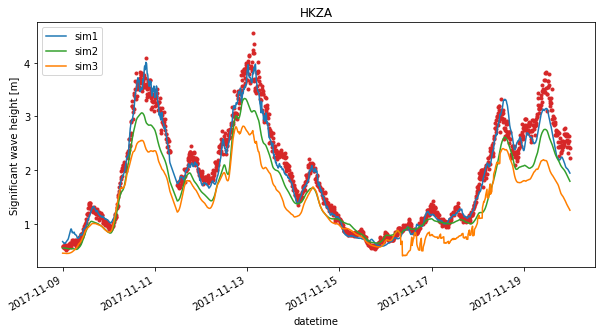

In [13]:
for stn in station_names:
    cc[stn].plot_timeseries(figsize=(10,5))
    plt.legend(loc='upper left')

## 4. Find best model 

In [14]:
meanskl = cc.mean_skill()
meanskl.round(3)


,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
sim1,2355,0.034,0.247,0.231,0.186,0.978,0.092,0.950
sim2,2355,-0.211,0.354,0.279,0.268,0.979,0.112,0.885
sim3,2355,-0.431,0.590,0.400,0.450,0.958,0.160,0.696


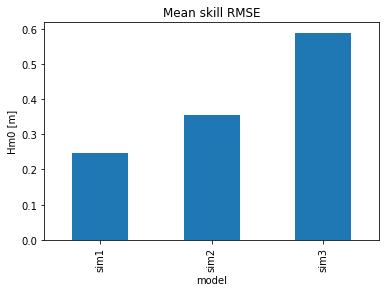

In [17]:
meanskl.plot_bar("rmse", title="Mean skill RMSE")
plt.ylabel("Hm0 [m]");